## Elogonation Classification with XGBoost and SHAP

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, roc_auc_score
import xgboost as xgb
import shap
import matplotlib.pyplot as plt
%matplotlib inline

shap.initjs()

## Data Preprocessing

In [2]:
rawdf = pd.read_csv('Elongation_class.CSV')
rawdf.head()

,C,SI,MN,P,S,CU,MG,CR,NI,PB,AL,MO,TI,SN,V,ZN,CE,ElongOK
0,3.56,2.83,0.34,0.013,0.009,0.05,0.052,0.041,0.029,0.001,0.011,0.004,0.008,0.004,0.004,0.001,0.006,1
1,3.58,2.79,0.28,0.012,0.010,0.05,0.051,0.046,0.029,0.002,0.010,0.005,0.007,0.004,0.004,0.001,0.006,1
2,3.59,2.99,0.34,0.013,0.007,0.07,0.064,0.048,0.031,0.003,0.012,0.016,0.007,0.005,0.004,0.002,0.007,1
3,3.69,2.92,0.36,0.014,0.009,0.06,0.049,0.048,0.034,0.004,0.009,0.015,0.008,0.004,0.004,0.002,0.006,1
4,3.64,3.00,0.41,0.012,0.009,0.06,0.038,0.046,0.032,0.005,0.010,0.005,0.007,0.004,0.005,0.095,0.007,1


In [3]:
df = rawdf.copy()

# feature scale
ss = MinMaxScaler()
scale_features = ['C','SI','MN']

df[scale_features] = ss.fit_transform(df[scale_features])

In [4]:
feature_loc = [
    'C', 'SI', 'MN', 'P', 'S', 'CU', 'MG', 'CR', 'NI', 'PB', 'AL', 'MO', 'TI',
    'SN', 'V', 'ZN', 'CE'
]
X = df.loc[:, feature_loc]
Y = df.ElongOK

print(X.shape, Y.shape)

(385, 17) (385,)


In [5]:
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=.2, random_state=0)
d_train = xgb.DMatrix(X_train, label=Y_train)
d_test = xgb.DMatrix(X_test,label=Y_test)

## The model select by TPOT

GradientBoostingClassifier(input_matrix, learning_rate=0.01, max_depth=6, max_features=0.35, min_samples_leaf=7, min_samples_split=15, n_estimators=100, subsample=0.3)

In [6]:
from xgboost import XGBClassifier

In [7]:
model =  XGBClassifier (
    learning_rate=0.01,
    max_depth=6,
    objective="binary:logistic",
    subsample= 0.3,
    base_score=np.mean(Y_train),
    n_estimator=100,
    max_features=0.35,
    min_samples_leaf=7,
    min_samples_split=15 
)
model.fit(X_train, Y_train, eval_metric='auc', verbose=True,
            eval_set=[(X_test, Y_test)], early_stopping_rounds=20)

[0]	validation_0-auc:0.94898
Will train until validation_0-auc hasn't improved in 20 rounds.
[1]	validation_0-auc:0.94898
[2]	validation_0-auc:0.939869
[3]	validation_0-auc:0.939869
[4]	validation_0-auc:0.952624
[5]	validation_0-auc:0.967201
[6]	validation_0-auc:0.955539
[7]	validation_0-auc:0.955539
[8]	validation_0-auc:0.954082
[9]	validation_0-auc:0.954082
[10]	validation_0-auc:0.954082
[11]	validation_0-auc:0.954082
[12]	validation_0-auc:0.943878
[13]	validation_0-auc:0.949708
[14]	validation_0-auc:0.955539
[15]	validation_0-auc:0.955539
[16]	validation_0-auc:0.955539
[17]	validation_0-auc:0.960277
[18]	validation_0-auc:0.960277
[19]	validation_0-auc:0.963921
[20]	validation_0-auc:0.967566
[21]	validation_0-auc:0.968659
[22]	validation_0-auc:0.968659
[23]	validation_0-auc:0.962828
[24]	validation_0-auc:0.962828
[25]	validation_0-auc:0.954811
[26]	validation_0-auc:0.956268
[27]	validation_0-auc:0.954811
[28]	validation_0-auc:0.953717
[29]	validation_0-auc:0.952988
[30]	validation_0-

XGBClassifier(base_score=0.36363636363636365, booster='gbtree',
       colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.01, max_delta_step=0, max_depth=6,
       max_features=0.35, min_child_weight=1, min_samples_leaf=7,
       min_samples_split=15, missing=None, n_estimator=100,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=0.3)

In [8]:
y_pre = model.predict(X_test)
y_pro = model.predict_proba(X_test)[:, 1]
print ("AUC Score : %f" % roc_auc_score(Y_test, y_pro))
print("Accuracy : %.4g%%" % (accuracy_score(Y_test, y_pre)*100))

AUC Score : 0.953353
Accuracy : 93.51%


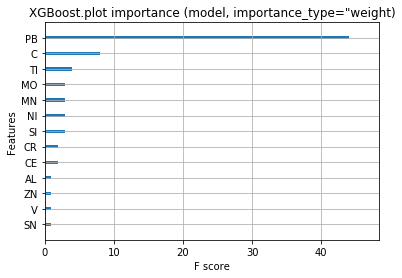

In [9]:
xgb.plot_importance(model,importance_type="weight",show_values=False)
plt.title('XGBoost.plot importance (model, importance_type="weight)')
plt.show()

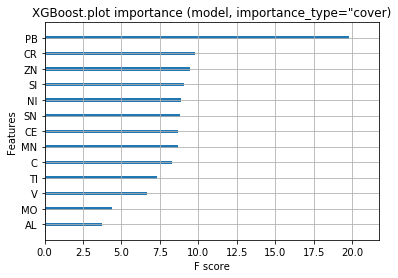

In [10]:
xgb.plot_importance(model,importance_type="cover",show_values=False)
plt.title('XGBoost.plot importance (model, importance_type="cover)')
plt.show()

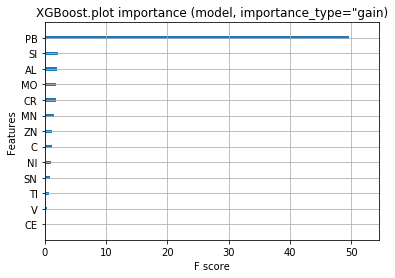

In [11]:
xgb.plot_importance(model,importance_type="gain",show_values=False)
plt.title('XGBoost.plot importance (model, importance_type="gain)')
plt.show()

In [12]:
shap_values = shap.TreeExplainer(model).shap_values(X)
shap.force_plot(shap_values[0,:], X.iloc[0,:],link="logit")

In [13]:
shap.force_plot(shap_values,X,link="logit")

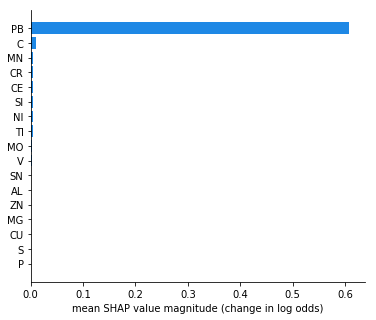

In [14]:
globat_shap_vals = np.abs(shap_values).mean(0)[:-1]
inds = np.argsort(globat_shap_vals)
y_pos = np.arange(X.shape[1])
plt.barh(y_pos, globat_shap_vals[inds], color='#1E88E5')
plt.yticks(y_pos, X.columns[inds])
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.xlabel("mean SHAP value magnitude (change in log odds)")
plt.gcf().set_size_inches(6,5)
plt.show()

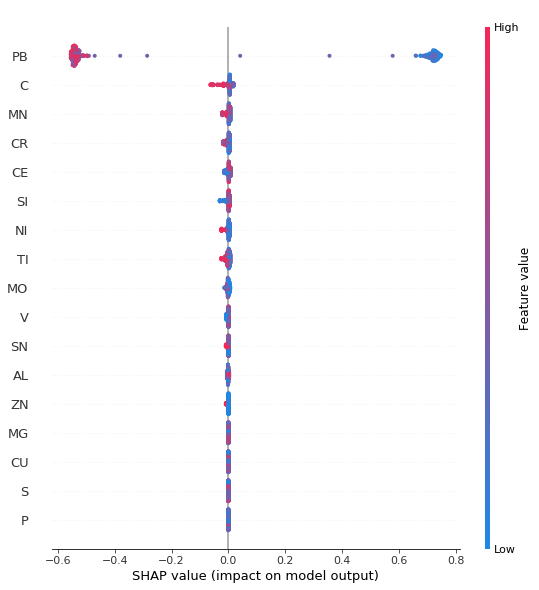

In [15]:
shap.summary_plot(shap_values, X)

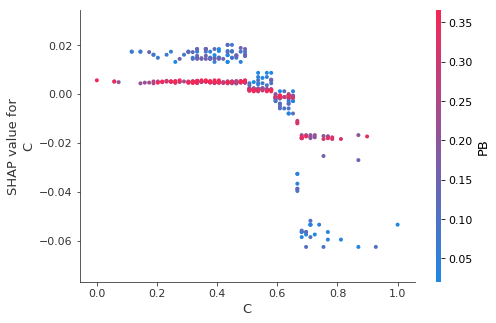

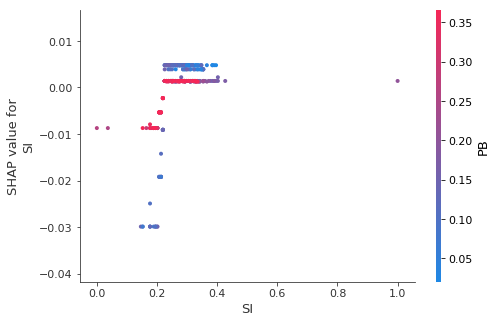

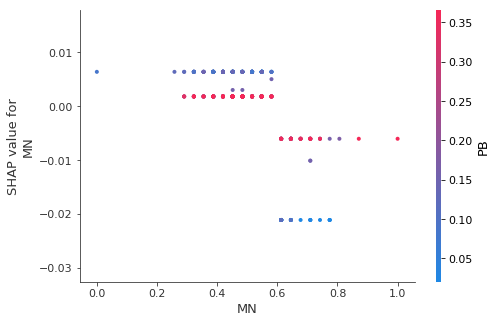

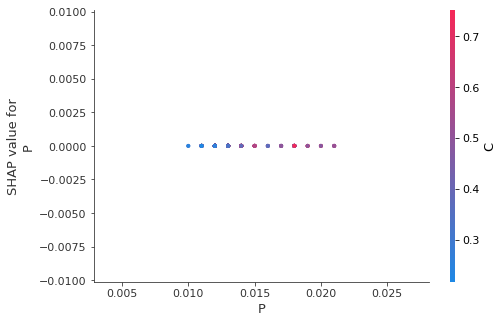

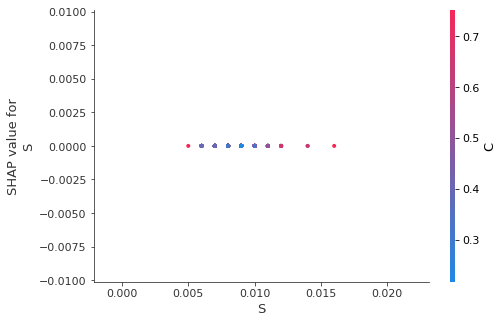

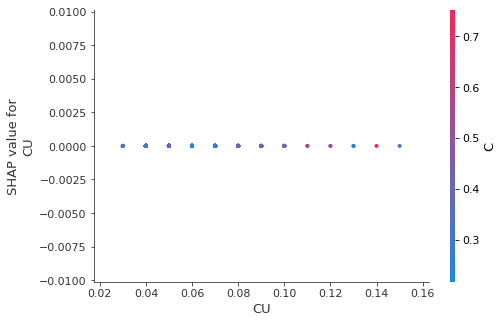

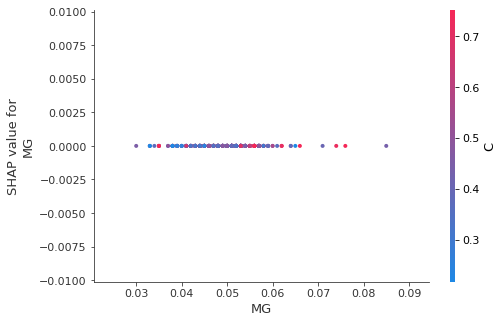

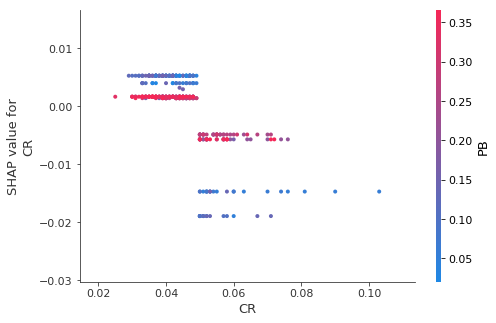

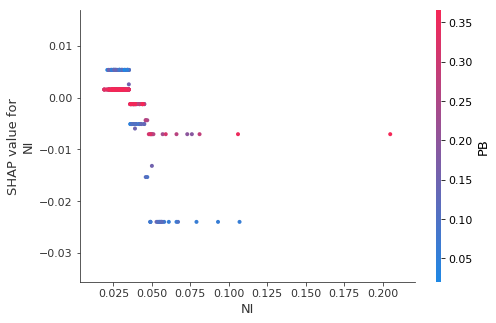

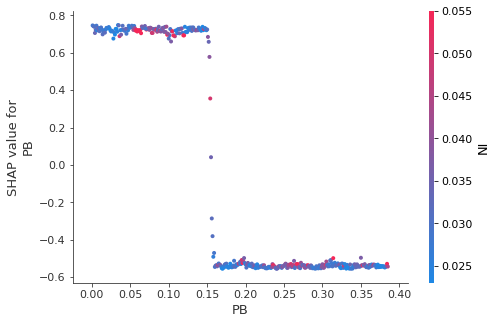

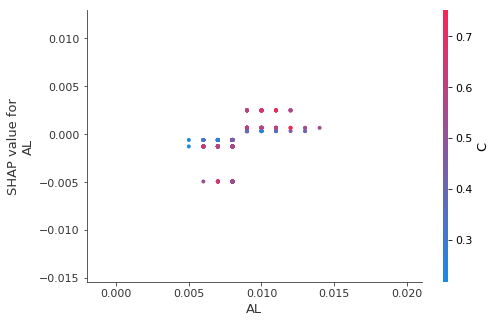

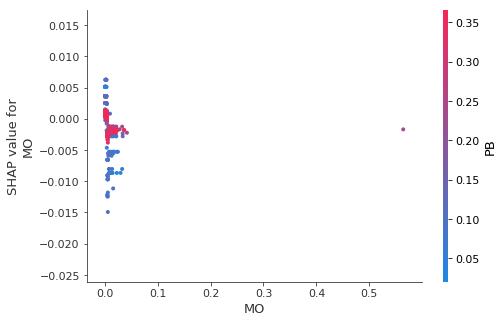

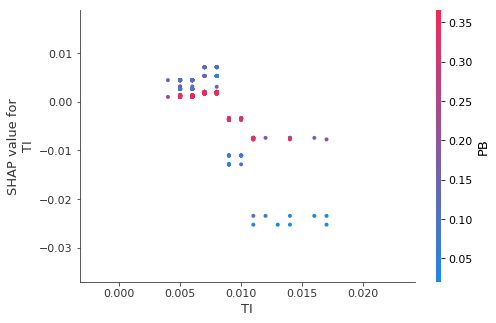

/home/chenshikun17/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3167: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/chenshikun17/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3168: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


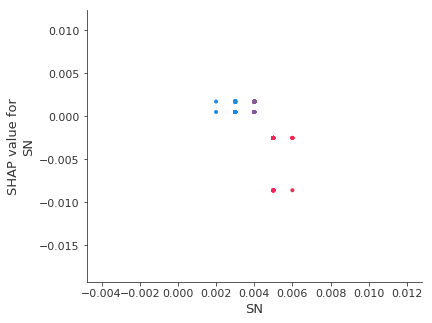

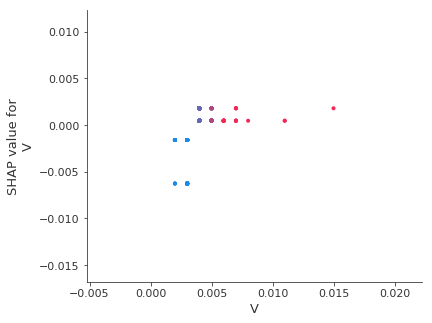

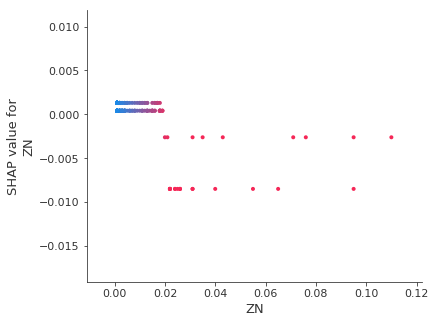

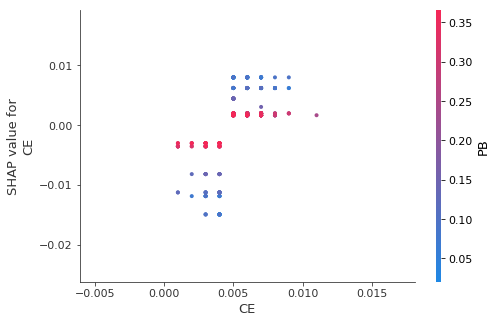

In [16]:
for name in X_train.columns:
    shap.dependence_plot(name, shap_values, X, display_features=X)